In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import PIL
import time

In [34]:
# mnist 데이터 로드하기 (training 이미지만 필요하므로 test 이미지는 생략)
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# input shape를 reshape 해주기
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# image normalize 해주기
train_images = (train_images - 127.5) / 127.5

In [35]:
# Sample size, batch size 설정하기
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# training 시 이용할 데이터 형성해주기 (training 이미지를 shuffle해주고, batch size로 자르기)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [36]:
# Generator model function 만들기
def make_generator_model():
    model = tf.keras.Sequential()

    # Dense layer (flat해서 input으로 받음)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # Batch normalization 수행
    model.add(layers.BatchNormalization())
    # Activation function : LeakyReLU 사용
    model.add(layers.LeakyReLU())

    # flatten된 것을 이미지 형태로 다시 reshape
    model.add(layers.Reshape((7, 7, 256)))
    
    # upsampling 수행 (이미지 크기 키우기)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Batch normalization 수행
    model.add(layers.BatchNormalization())
    # Activation function : LeakyReLU 사용
    model.add(layers.LeakyReLU())

    # unsampling 다시 수행
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Batch normalization 수행 
    model.add(layers.BatchNormalization())
    # Activation function : LeakyReLU 사용
    model.add(layers.LeakyReLU())

    # upsampling 다시 수행 (크기 28*28*1)
    # 원래 이미지는 channel size가 1이므로 
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

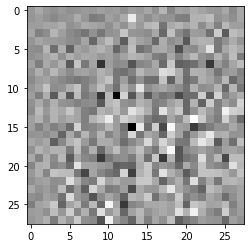

In [37]:
# Generator model 만들기
generator = make_generator_model()

# 100개의 noise 넣기
noise = tf.random.normal([1, 100])
# training이 아니라 inference하기
generated_image = generator(noise, training=False)

# 나온 이미지 보여주기
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [38]:
# Discriminator model function 만들기
def make_discriminator_model():
    model = tf.keras.Sequential()

    # convolution 수행
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    # Activation function 수행
    model.add(layers.LeakyReLU())
    # Dropout 수행
    model.add(layers.Dropout(0.3))

    # convolution 수행
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # Activation function 수행
    model.add(layers.LeakyReLU())
    # Dropout 수행
    model.add(layers.Dropout(0.3))

    # 1D로 flatten
    model.add(layers.Flatten())
    # Dense layer
    model.add(layers.Dense(1))

    return model

In [39]:
# discriminator 만들기
discriminator = make_discriminator_model()
# 이미지가 real인지 여부를 실험해보기
decision = discriminator(generated_image)
# 결과 출력
print (decision)

tf.Tensor([[0.00063601]], shape=(1, 1), dtype=float32)


In [40]:
# loss function 정의하기
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [41]:
# Discriminator loss 정의하기
def discriminator_loss(real_output, fake_output):
    # 1과 비교해서 real image loss 생성
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 0과 비교해서 fake image loss 생성
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # 총 loss는 위의 두가지 더한 값
    # discriminator는 이 loss를 minimize함
    total_loss = real_loss + fake_loss
    return total_loss

In [42]:
# Generator loss 정의하기
def generator_loss(fake_output):
    # 1과 비교해서 fake output loss 생성
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [43]:
# generator과 discriminator의 optimizer 지정하기
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [44]:
# training을 위한 epochs, noise dimension, sample 개수 설정
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# seed 만들기
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [45]:
# 학습을 위한 함수 만들기
@tf.function
def train_step(images):
    # 학습을 위한 noise를 만들기
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 두개의 gradient tape 만들기
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # generator 통해서 image 만들기
      generated_images = generator(noise, training=True)

      # discriminator에 real image와 generator가 생성한 image 넣기
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # generator와 discriminator loss 구하기
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # backpropagation
    # generator과 discriminator의 gradient 계산하기
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # generator와 discriminator 각각 optimizer에서 정해준대로 weight 업데이트 수행하기
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [46]:
# training loop 만들기
def train(dataset, epochs):
  # epoch에 대한 loop
  for epoch in range(epochs):
    # 1개의 epoch 당 걸리는 시간 측정하기
    start = time.time()

    # batch마다 training 진행
    for image_batch in dataset:
      train_step(image_batch)

    # epoch 시간 출력하기
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  # generator에 output을 넣어서 실제 이미지가 어떻게 생성되는지 보기
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [47]:
# generator가 생성한 이미지 보기
def generate_and_save_images(model, epoch, test_input):
  # training한 것을 predict
  predictions = model(test_input, training=False)
  
  # 해당 이미지 출력하기
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

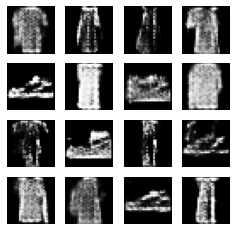

In [48]:
# training 수행하고 생성한 이미지 보기
train(train_dataset, EPOCHS)